# Penalty Methods

Penalty methods have been superseded by more effective methods and are rarely used anymore, but they are easy to understand and provide a good jumping off point.  Consider the simple example:

$$
\begin{align*}
\text{minimize} &\quad  x_1 + x_2\\
\text{subject to} &\quad  x_1^2 + x_2^2 = 8\\
\end{align*}
$$

In [25]:
def func(x):

    f = x[0] + x[1]
    c = x[0]**2 + x[1]**2 - 8
    
    return f, c

Let's use a simple quadratic penalty of the form
$$F(x; \mu) = f(x) + \frac{\mu}{2}\sum_i \hat{c}_i(x)^2$$

In [26]:
def quadpenalty(x, mu):
    
    f, c = func(x)
    P = mu/2.0*c**2
    return f + P

Let's plot contours of the original function.  (Note I am using colormaps.py from [here](https://github.com/BIDS/colormap) because Matplotlib 1.x doesn't have the new colormaps).

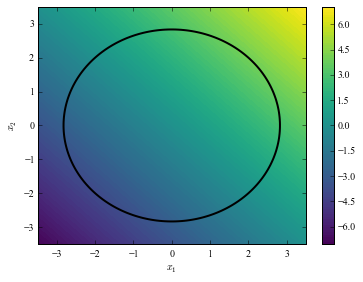

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import colormaps as cmaps

n = 100
x0 = np.linspace(-3.5, 3.5, n)
x1 = np.linspace(-3.5, 3.5, n)
[X0, X1] = np.meshgrid(x0, x1, indexing='ij')

F = np.zeros((n, n))
C = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        F[i, j], C[i, j] = func([X0[i, j], X1[i, j]])


plt.figure()
plt.contourf(X0, X1, F, 100, cmap=cmaps.viridis)
plt.colorbar()
plt.contour(X0, X1, C, levels=[0], linewidths=2, colors='k')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

Now let's plot what our unconstrained quadratic penalty function looks like for some value of $\mu$.

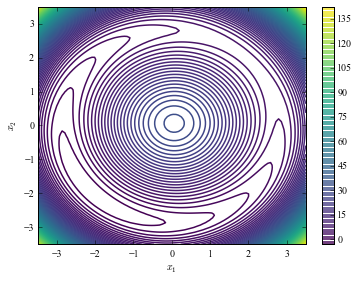

In [28]:
mu = 1.0

F = np.zeros((n, n))
C = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        F[i, j] = quadpenalty([X0[i, j], X1[i, j]], mu)
        
plt.figure()
plt.contour(X0, X1, F, 100, cmap=cmaps.viridis)
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

The minimum, is near, but not exactly at the solution $x^* = (-2, -2)$.  As we increase the value of $\mu$, the solution to the unconstrained problem gets nearer the actual solution, but the optimization problem becomes increasingly harder to solve because of the poor scaling.

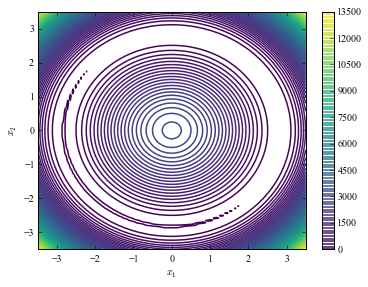

In [29]:
mu = 100.0

F = np.zeros((n, n))
C = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        F[i, j] = quadpenalty([X0[i, j], X1[i, j]], mu)
        
plt.figure()
plt.contour(X0, X1, F, 100, cmap=cmaps.viridis)
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

Conversely, if the penalty is not steep enough to begin with, then the problem may be unbounded from below.

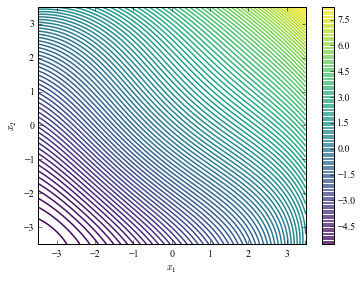

In [34]:
mu = 0.01

F = np.zeros((n, n))
C = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        F[i, j] = quadpenalty([X0[i, j], X1[i, j]], mu)
        
plt.figure()
plt.contour(X0, X1, F, 100, cmap=cmaps.viridis)
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

Let's iteratively optimize this unconstrained problem with different values of $\mu$ and see the change in the objective value and x value.  Note that both x values are the same because of the symmetry of the problem, so we just plot one.

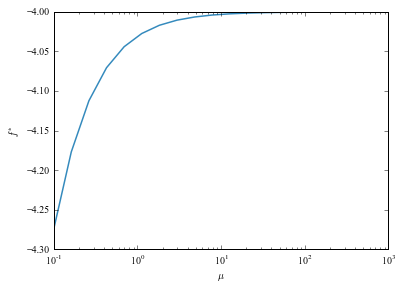

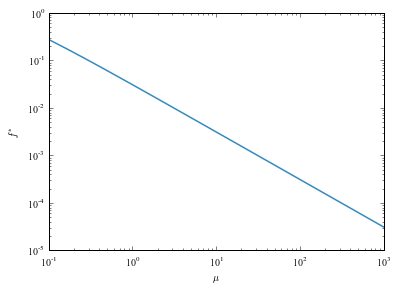

In [55]:
import pyoptsparse

def opt(xdict):  # return both f and c

    x = xdict['x']  # uses a dictionary with whatever keys you define below
    f = quadpenalty(x, mu)
    
    outputs = {}
    outputs['obj'] = f 
    
    fail = False  # can use a flag to denote a failure, optimizer will try to recover and progress
    
    return outputs, fail


# starting point
x0 = [0.0, 0.0]

# define the problem.  Use same keys as above.
optProb = pyoptsparse.Optimization('penalty', opt)
optProb.addObj('obj')
optProb.addVarGroup('x', len(x0), type='c', value=x0)

# choose the solver, in this case SNOPT
opt = pyoptsparse.SNOPT()
opt.setOption('Major feasibility tolerance', 1e-6)
opt.setOption('Major optimality tolerance', 1e-6)
opt.setOption('iPrint', 6)  # normally you would not want to do this, but this notebook can't write files.  In general, you'll get two output files with detailed information.
opt.setOption('iSumm', 6)

# iterate
n = 20
muvec = np.logspace(-1, 3, n)
fstar = np.zeros(n)
xstar = np.zeros(n)

for i, mu in enumerate(muvec):
    sol = opt(optProb, sens='FD')  # finite difference

#     xstar[i] = sol.xStar['x'][0]  # just take one of x values since both are same
    fstar[i] = sol.fStar

plt.figure()
plt.semilogx(muvec, fstar)
plt.xlabel('$\mu$')
plt.ylabel('$f^*$')

plt.figure()
plt.loglog(muvec, np.abs(fstar) - 4.0)
plt.xlabel('$\mu$')
plt.ylabel('$f^*$')


Notice that to achieve reasonable accuracies, we need to make $\mu$ fairly large.  For more complicated problems in higher dimensions, the scaling is very poor and it is difficult to solve with large $\mu$.  Generally, you have to settle for a highly approximate solution using this approach.